In [1]:
import os, re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sgutil, sgml

for i in [pd, np, sns, mpl]:
    print(i.__name__, i.__version__)

pandas 2.2.2
numpy 1.26.4
seaborn 0.13.2
matplotlib 3.8.4


In [2]:
# 주요 파일의 경로를 설정합니다.
data_path = 'data'
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'data.csv'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}
# fig, result cache 처리기를 생성합니다.
sc = sgutil.SGCache('img', 'result')
# 처리된 데이터를 불러옵니다.
df_train = pd.read_pickle(files['train_pkl'])
df_test = pd.read_pickle(files['test_pkl'])
df_org = pd.read_pickle(files['org_pkl'])
df_var = pd.read_pickle(files['var_pkl'])
# 변수를 유형별로 정리합니다.
target = 'Target'
X_cat = [i for i in df_var.loc[df_var['src'] == 'filtering_cat_val'].index.tolist() if i != target]
X_cat_o = [i for i in df_var.loc[df_var['src'] == 'ord'].index.tolist() if i != target]
X_bool = [
    'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]
X_ord = ['Application order']
X_num = df_var.loc[(~df_var.index.isin(X_cat + X_bool + X_ord + [target])) & df_var['Type'].notna()].index.tolist()
X_all = X_cat_o + X_bool + X_ord + X_num

In [3]:
df_var_agg = df_var.groupby(level=0)[['Role', 'Type', 'Demographic', 'Description', 'src', 'var_type']].apply(
    lambda x: x.apply(lambda y: '→'.join(y.dropna()))
)
df_var_agg

,Role,Type,Demographic,Description,src,var_type
Admission grade,Feature,Continuous,,Admission grade (between 0 and 200),org,Float32
Age at enrollment,Feature,Integer,Age,Age of studend at enrollment,org,Int8
Application mode,Feature,Integer,,1 - 1st phase - general contingent 2 - Ordinan...,org→filtering_cat_val,Int8→Int8
Application mode_r,,,,"Application mode: {2: 10, 26: 10, 27: 10, -1: 10}",repl_cat_val,Int64
Application mode_r__o,,,,OrdinalEncoder: Application mode_r,ord,Int16
Application order,Feature,Integer,,Application order (between 0 - first choice; a...,org,Int8
Course,Feature,Integer,,33 - Biofuel Production Technologies 171 - Ani...,org→filtering_cat_val,Int16→Int16
Course__o,,,,OrdinalEncoder: Course,ord,Int16
Curricular units 1st sem (approved),Feature,Integer,,Number of curricular units approved in the 1st...,org,Int8
Curricular units 1st sem (credited),Feature,Integer,,Number of curricular units credited in the 1st...,org,Int8


In [4]:
s_unique = sc.cache_result(
    'unique_num',
    lambda : df_train[df_var_agg.loc[df_var_agg['Role'] != 'Target'].index.tolist()].nunique(), rerun=True
)
s_unique.sort_values(ascending=False)

Curricular units 2nd sem (grade)                  1142
Curricular units 1st sem (grade)                  1135
Admission grade                                    668
Previous qualification (grade)                     110
Father's occupation                                 47
Age at enrollment                                   46
Curricular units 1st sem (evaluations)              36
Father's qualification                              35
Mother's occupation                                 33
Father's occupation_r                               31
Curricular units 2nd sem (evaluations)              31
Father's occupation_r__o                            31
Mother's qualification                              30
Mother's occupation_r                               28
Mother's occupation_r__o                            28
Father's qualification_r                            24
Mother's qualification_r                            24
Mother's qualification_r__o                         24
Father's q

# Target

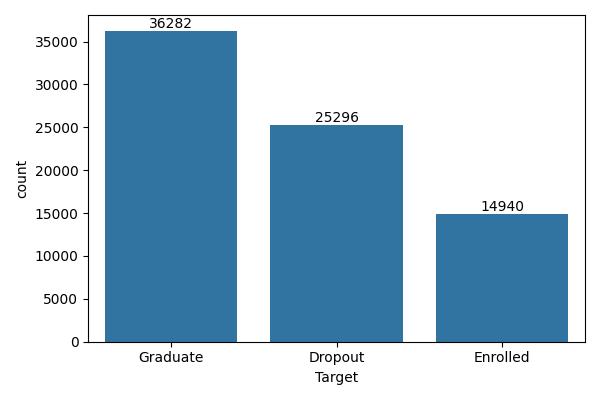

In [5]:
sc.cache_fig(
    'target_count',
    lambda x: [x.bar_label(i) for i in sns.barplot(df_train['Target'].value_counts(), ax=x).containers],
    figsize=(6, 4)
)

# Train과 Test의 차이

In [6]:
df_istrain = pd.concat([
    df_train.assign(is_train=1),
    df_test.assign(is_train=0)
], axis = 0)

In [7]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

def predict_is_train(m, df_valid, X):
    return pd.Series(m.predict_proba(df_valid[X])[:, 1], index=df_valid.index)
def eval_metric_is_train(y_true, prds):
    return roc_auc_score(y_true.sort_index()['is_train'], prds.sort_index())

is_train_result = sc.cache_result(
    'is_train_result',
    lambda : sgml.cv_model(
        StratifiedKFold(n_splits=5, random_state=123, shuffle=True), 
        lgb.LGBMClassifier, {'verbose': -1, 'n_estimators': 500}, df_istrain, X_all, 'is_train',
        result_proc=sgml.lgb_learning_result,
        predict_func=predict_is_train, eval_metric = eval_metric_is_train,
        train_params={
            'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x['is_train'], random_state=123),
            'fit_params': {'categorical_feature': X_cat_o, 'callbacks': [lgb.early_stopping(5, verbose=False)]},
            'valid_config_proc': sgml.gb_valid_config
        }
    )
)

In [8]:
np.mean(is_train_result[0]), np.mean(is_train_result[1])

(0.8024451073185057, 0.7621756193562584)

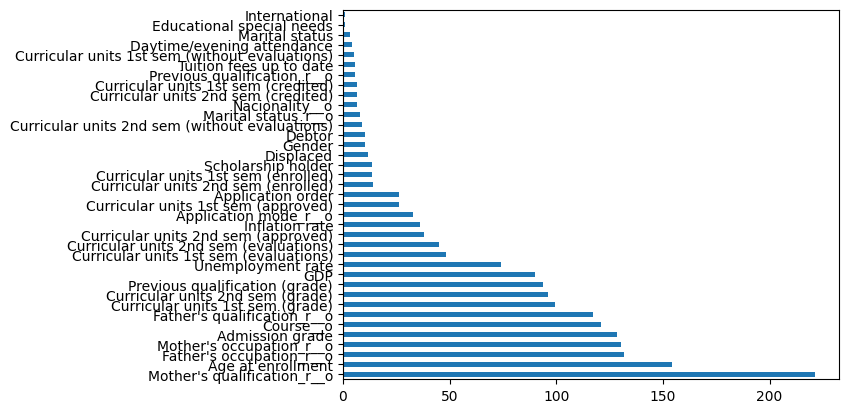

In [9]:
pd.concat([i[1] for i in is_train_result[3]], axis=1).mean(axis=1).sort_values(ascending=False).plot(kind='barh')
plt.show()

학습/평가 데이터를 분류하는 교차검증을 해본결과 

학습 데이터와 평가 데이터는 차이가 극명히 존재합니다. 살펴봅니다.

## Chi2 Test

In [10]:
from scipy.stats import chi2_contingency

sc.cache_result(
    'dis_train_test_chi2',
    lambda : pd.Series([
        chi2_contingency(
            df_istrain.pivot_table(index='is_train', columns=i, aggfunc='size', observed=True).fillna(0)
        )[1] for i in s_unique.loc[s_unique < 50].index
    ], index =s_unique.loc[s_unique < 50].index)
).sort_values()

Mother's qualification_r__o                       0.000000e+00
Father's occupation_r__o                          6.094056e-30
Debtor                                            1.467059e-02
Curricular units 2nd sem (evaluations)            2.660069e-02
Application order                                 4.530812e-02
Daytime/evening attendance                        5.921286e-02
International                                     6.734669e-02
Curricular units 1st sem (evaluations)            1.105682e-01
Course                                            1.220967e-01
Course__o                                         1.220967e-01
Curricular units 2nd sem (credited)               1.301952e-01
Scholarship holder                                1.339808e-01
Curricular units 2nd sem (approved)               1.477417e-01
Curricular units 1st sem (approved)               1.705001e-01
Marital status_r                                  2.132955e-01
Marital status_r__o                               2.132

독립성 검정 결과에서는 train / test 상에서 분포는 크게 차이나지 않습니다.

## T-test

In [11]:
from scipy.stats import ttest_ind, bartlett

sc.cache_result('is_train_ttest',
    lambda : pd.Series([
        df_istrain.groupby('is_train', observed=True)[i].agg(list).pipe(
            lambda x: ttest_ind(*x, equal_var=(bartlett(*x).pvalue >= 0.05)).pvalue
        )
        for i in X_num
    ], index=X_num), rerun=True
)

Marital status                                    0.257877
Previous qualification (grade)                    0.416462
Admission grade                                   0.437435
Age at enrollment                                 0.065637
Curricular units 1st sem (credited)               0.302940
Curricular units 1st sem (enrolled)               0.209228
Curricular units 1st sem (evaluations)            0.043939
Curricular units 1st sem (approved)               0.010486
Curricular units 1st sem (grade)                  0.001967
Curricular units 1st sem (without evaluations)    0.948296
Curricular units 2nd sem (credited)               0.131107
Curricular units 2nd sem (enrolled)               0.244455
Curricular units 2nd sem (evaluations)            0.045199
Curricular units 2nd sem (approved)               0.039357
Curricular units 2nd sem (grade)                  0.008450
Curricular units 2nd sem (without evaluations)    0.607498
Unemployment rate                                 0.9857

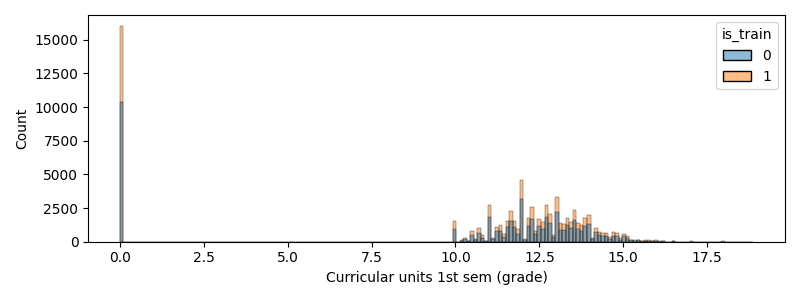

In [12]:
sc.cache_fig('is_train_plot',
    lambda x: sns.histplot(df_istrain, x='Curricular units 1st sem (grade)', hue='is_train', ax=x)
)

# 범주형 변수

## 노이즈 제거

원래 데이터셋의 범주형 변수의 범주에 대한 설명이 있습니다. 

범주형 변수 전반적으로 소수만 등장하는 범주들이 있고, 이들은 원래 데이터셋에서는 설명이 등장하지 않습니다.

이 범주형 값을 정리하여 -1 로 정리 됩니다. 이 과정은 data processing에 의해 진행됩니다.

## Common

In [13]:
def desc_val_counts(var_name, desc_name = None):
    desc_name = var_name if desc_name is None else desc_name
    return pd.Series(re.split("(?P<no>[0-9]+ - )", df_var_agg.loc[desc_name, "Description"])[1:])\
        .rename(index=lambda x: 'no' if x % 2 == 0 else 'desc').rename('var').reset_index().assign(
            item=lambda x: x.index // 2,
        ).pivot(index='item', columns='index', values='var')\
        .assign(
            no=lambda x: x['no'].str.slice(0, -2).astype('int'),
        ).set_index('no').join(
            df_train[var_name].astype('int').value_counts().rename('train_count'), how='outer'
        ).join(
            df_test[var_name].astype('int').value_counts().rename('test_count'), how='outer'
        )

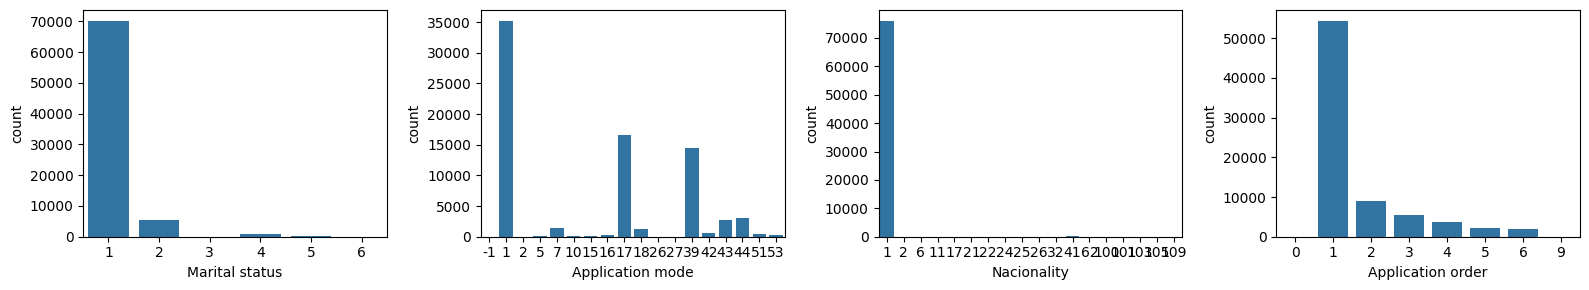

In [14]:
sc.cache_fig(
    'freq_plot_1', 
    lambda x: [sns.barplot(df_train[i].value_counts(), ax=ax) 
     for ax, i in zip(x, ['Marital status', 'Application mode', 'Nacionality', 'Application order'])],
    nrow=1, ncol=4, figsize=(16, 3), redraw=True
)   

## Course

In [15]:
sc.cache_result(
    'course_count', lambda : desc_val_counts('Course')
)

,desc,train_count,test_count
-1,NaN,2,4
33,Biofuel Production Technologies,72,42
171,Animation and Multimedia Design,2859,1792
8014,Social Service (evening attendance),2438,1531
9003,Agronomy,3733,2535
9070,Communication Design,3281,2267
9085,Veterinary Nursing,5373,3511
9119,Informatics Engineering,3004,1935
9130,Equinculture,1606,1138
9147,Management,7741,5042


## Application mode

In [16]:
sc.cache_result(
    'Application mode_target',
    lambda : pd.concat([
        pd.crosstab(
            index=df_train['Application mode'], columns=df_train[target], normalize='index'
        ), df_train['Application mode'].value_counts()
    ], axis=1)
)

,Graduate,Dropout,Enrolled,count
Application mode,,,,
-1,0.800000,0.200000,0.000000,5
1,0.610611,0.187782,0.201607,35227
2,0.750000,0.125000,0.125000,8
5,0.471264,0.206897,0.321839,87
7,0.214286,0.721629,0.064085,1498
10,0.558140,0.232558,0.209302,43
15,0.459016,0.224044,0.316940,183
16,0.660377,0.154717,0.184906,265
17,0.494704,0.292380,0.212915,16523


In [17]:
sc.cache_result(
    'application mode count', lambda : desc_val_counts('Application mode')
)

,desc,train_count,test_count
-1,NaN,5.0,4.0
1,1st phase - general contingent,35227.0,23357.0
2,Ordinance No. 612/93,8.0,3.0
5,1st phase - special contingent (Azores Island),87.0,79.0
7,Holders of other higher courses,1498.0,1011.0
10,Ordinance No. 854-B/99,43.0,20.0
15,International student (bachelor),183.0,119.0
16,1st phase - special contingent (Madeira Island),265.0,198.0
17,2nd phase - general contingent,16523.0,11207.0
18,3rd phase - general contingent,1256.0,788.0


정리할 만한 요소가 무엇인지 봅니다.

In [18]:
[
    chi2_contingency(
        df_train.loc[df_train['Application mode'].isin(i)]\
            .pivot_table(index='Application mode', columns=target, aggfunc='size', observed=True).fillna(0)
    )[1] for i in [[1, 17, 18], [1, 5, 16], [2, 10, 26, 27, -1]]
]

[3.995024303338084e-228, 0.016327209005826956, 0.8403865860727073]

2 → 10, 26 → 10, 27 → 10, -1 → 10

In [19]:
sc.cache_result(
    'Application mode count_r', lambda : desc_val_counts('Application mode_r', 'Application mode')
).dropna()

,desc,train_count,test_count
1,1st phase - general contingent,35227.0,23357.0
5,1st phase - special contingent (Azores Island),87.0,79.0
7,Holders of other higher courses,1498.0,1011.0
10,Ordinance No. 854-B/99,59.0,28.0
15,International student (bachelor),183.0,119.0
16,1st phase - special contingent (Madeira Island),265.0,198.0
17,2nd phase - general contingent,16523.0,11207.0
18,3rd phase - general contingent,1256.0,788.0
39,Over 23 years old,14519.0,9585.0
42,Transfer,551.0,347.0


## Father's occupation

In [20]:
df_fo = sc.cache_result(
    "Father's occupation count", lambda : desc_val_counts("Father's occupation")
).sort_values('train_count', ascending=False).assign(
    desc = lambda x: x['desc'].str.lower()
)
df_fo

,desc,train_count,test_count
9,unskilled workers,22320,14961.0
7,"skilled workers in industry, construction and ...",12910,8648.0
5,"personal services, security and safety workers...",9661,6467.0
4,administrative staff,6668,4374.0
3,intermediate level technicians and professions,5663,3808.0
8,installation and machine operators and assembl...,5111,3407.0
10,armed forces professions,4107,2786.0
6,"farmers and skilled workers in agriculture, fi...",2922,1943.0
2,specialists in intellectual and scientific act...,2236,1418.0
0,student,2056,1335.0


## Mother's occupation

In [21]:
df_mo = sc.cache_result(
    "Mother's occupation count", lambda : desc_val_counts("Mother's occupation")
).sort_index()
df_mo

,desc,train_count,test_count
-1,NaN,8,6
0,Student,2206,1456
1,Representatives of the Legislative Power and E...,766,540
2,Specialists in Intellectual and Scientific Act...,4087,2646
3,Intermediate Level Technicians and Professions,4644,3131
4,Administrative staff,16062,10700
5,"Personal Services, Security and Safety Workers...",9452,6234
6,"Farmers and Skilled Workers in Agriculture, Fi...",786,519
7,"Skilled Workers in Industry, Construction and ...",4207,2855
8,Installation and Machine Operators and Assembl...,243,175


이 변수들은 범주형으로 다루어서는 평가 데이터에 대한 예측 성능을 기대하기 힘들어 보입니다. 범주가 지닌 텍스트를 기반으로 접근을 해볼만합니다.

→ Target에 대한 비율을 가지고 계층적 구집화를 해봅니다.

In [48]:
df_jd = pd.concat([df_fo['desc'], df_mo['desc']]).str.lower().str.strip().dropna().drop_duplicates()\
    .reset_index().assign(index=lambda x: x['index'].astype('int')).set_index('index')
df_jd.sort_index()

,desc
index,
0,student
1,representatives of the legislative power and e...
2,specialists in intellectual and scientific act...
3,intermediate level technicians and professions
4,administrative staff
5,"personal services, security and safety workers..."
6,"farmers and skilled workers in agriculture, fi..."
7,"skilled workers in industry, construction and ..."
8,installation and machine operators and assembl...


In [49]:
df_oc_count = sc.cache_result('occupation count', 
    lambda : pd.concat([
        pd.concat([
        df_train.loc[:, "Father's occupation"], 
        df_train.loc[:, "Mother's occupation"]
        ], axis=0).value_counts().rename('count'), df_jd
    ], axis=1)
)
df_oc_count

,count,desc
9,54706,unskilled workers
4,22730,administrative staff
5,19113,"personal services, security and safety workers..."
7,17117,"skilled workers in industry, construction and ..."
3,10307,intermediate level technicians and professions
2,6323,specialists in intellectual and scientific act...
8,5354,installation and machine operators and assembl...
0,4262,student
10,4125,armed forces professions
6,3708,"farmers and skilled workers in agriculture, fi..."


In [52]:
df_oc_count.loc[1, 'desc']

'representatives of the legislative power and executive bodies, directors, directors and executive managers'

저빈도 직업은 상위 직업으로 대체합니다.

In [47]:
df_ratio = pd.concat([
        df_train.loc[:, ["Father's occupation_r", target]].rename(
            columns = {"Father's occupation_r": 'occupation'}
        ), 
        df_train.loc[:, ["Mother's occupation_r", target]].rename(
            columns = {"Mother's occupation_r": 'occupation'}
        )], axis=0)\
        .pivot_table(index="occupation", columns=target, aggfunc='size', observed=False).fillna(0).pipe(
            lambda x: x.div(x.sum(axis=1), axis = 0)
        ).reset_index().join(df_jd, on='occupation', how='inner')

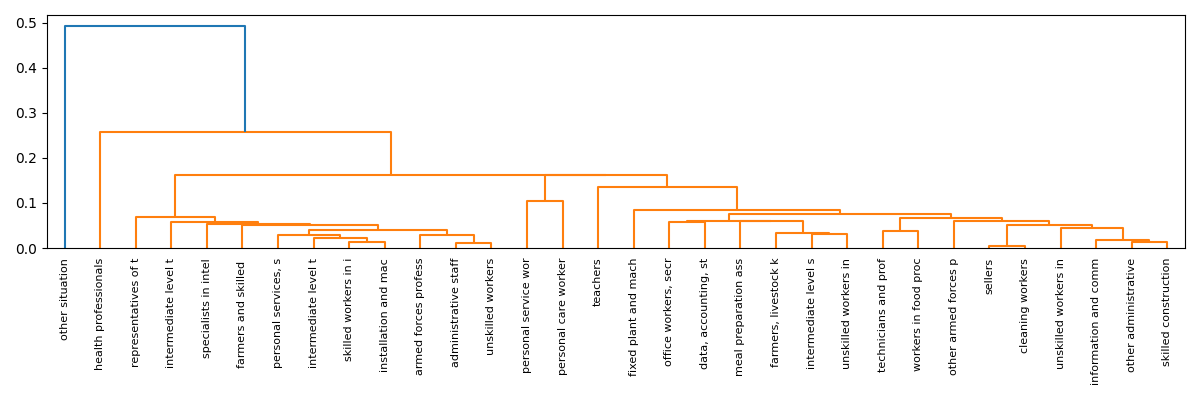

In [48]:
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
def plot_dendrogam_ratio(ax, df_ratio):
    Z = hierarchy.linkage(pdist(df_ratio.iloc[:, 1:4]), method='single')
    hierarchy.dendrogram(Z, labels=df_ratio['desc'].str.slice(0, 20).values, ax=ax)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
sc.cache_fig('plot_dendrogam_job_ratio', lambda x: plot_dendrogam_job_ratio(x, df_ratio), figsize=(12, 4))

## Marital status

In [158]:
sc.cache_result(
    'marital_target',
    lambda : pd.concat([
        pd.crosstab(
            index=df_train['Marital status'], columns=df_train[target], normalize='index'
        ), df_train['Marital status'].value_counts()
    ], axis=1)
)

,Graduate,Dropout,Enrolled,count
Marital status,,,,
1,0.490490,0.309536,0.199974,70189
2,0.300793,0.560423,0.138784,5296
3,0.437500,0.437500,0.125000,16
4,0.242494,0.587760,0.169746,866
5,0.344828,0.543103,0.112069,116
6,0.142857,0.657143,0.200000,35


In [159]:
df_var.loc['Marital status', 'Description']

'1 – single 2 – married 3 – widower 4 – divorced 5 – facto union 6 – legally separated'

빈도수가 적고 의미상 통합할 만한 범주들이 보입니다.

Application mode은 일부 범주의 빈도가 적습니다. 이를 정리할 방법을 찾아볼 필요가 있어보입니다.

Chi2 Test로 target과 독립인 범주들은 정리합니다.

In [160]:
[
    chi2_contingency(
        df_train.loc[df_train['Marital status'].isin(i)]\
            .pivot_table(index='Marital status', columns=target, aggfunc='size', observed=True)
    )[1] for i in [[4, 6], [1, 3], [2, 5]]
]

[0.39574425313329825, 0.4997204286907325, 0.5024732076264273]

비슷한 의미의 범주를 가지고 있는 6 → 4, 3 → 1, 5 → 2 로 치환해도 무방해보입니다.

In [161]:
sc.cache_result(
    'marital_r_target',
    lambda : pd.concat([
        pd.crosstab(
            index=df_train['Marital status_r'], columns=df_train[target], normalize='index'
        ), df_train['Marital status_r'].value_counts()
    ], axis=1)
)

,Graduate,Dropout,Enrolled,count
Marital status_r,,,,
1,0.490478,0.309565,0.199957,70205
2,0.301737,0.560052,0.138211,5412
4,0.238624,0.590455,0.170921,901


## Nacionality & International

Nacionality는 0에 치우침이 심합니다.

In [32]:
sc.cache_result(
    'Nacionality_count', lambda : desc_val_counts('Nacionality')
).sort_values('train_count', ascending=False)

,desc,train_count,test_count
1,Portuguese;,76013.0,50719.0
41,Brazilian;,221.0,106.0
26,Santomean;,67.0,37.0
22,Cape Verdean;,56.0,36.0
6,Spanish;,56.0,33.0
11,Italian;,15.0,9.0
24,Guinean;,15.0,13.0
2,German;,13.0,8.0
103,Ukrainian;,12.0,7.0
100,Moldova (Republic of);,9.0,8.0


In [ ]:
41: 2, 26: 3, 22: 3, 6: 4, 11: 4, 24: 3, 2: 4, 103: 5, 100: 5, 101: 2, 105: 5, 21: 6, 25: 6, 62: 5, 17: 5, 109: 2, 32: 5, 14: 3

In [33]:
sc.cache_result(
    'Nacionality International_target',
    lambda : pd.concat([
        pd.crosstab(
            index=df_train['Nacionality'].astype('str') + '_' + df_train['International'].astype('str'), 
            columns=df_train[target], normalize='index'
        ), (df_train['Nacionality'].astype('str') + '_' + df_train['International'].astype('str')).value_counts()
    ], axis=1)
).sort_values('count', ascending=False)

,Graduate,Dropout,Enrolled,count
1_0,0.474122,0.330535,0.195343,76010
41_1,0.420814,0.429864,0.149321,221
26_1,0.537313,0.179104,0.283582,67
6_1,0.357143,0.392857,0.250000,56
22_1,0.618182,0.272727,0.109091,55
11_1,0.933333,0.066667,0.000000,15
24_1,0.733333,0.066667,0.200000,15
2_1,1.000000,0.000000,0.000000,13
103_1,0.666667,0.083333,0.250000,12
101_1,0.111111,0.666667,0.222222,9


In [61]:
df_var.loc['Nacionality', 'Description']

Nacionality    1 - Portuguese; 2 - German; 6 - Spanish; 11 - ...
Nacionality                         i: 설명에 등장하지 않은 변수를 -1로 치환합니다
Name: Description, dtype: object

Nacionality은 일부 범주의 빈도가 적습니다. 이를 정리할 방법을 찾아볼 필요가 있어보입니다.

In [62]:
sc.cache_result(
    'Nacionality_GDP',
    lambda : df_train.pivot_table(index='Nacionality', columns='GDP', aggfunc='size', observed=True).fillna(0)
)

GDP,-4.06,-3.12,-1.70,-0.92,0.32,0.74,0.79,1.74,1.79,2.02,3.51
Nacionality,,,,,,,,,,,
1,6712.0,10149.0,7330.0,6117.0,10398.0,1.0,5744.0,9357.0,8422.0,6753.0,5030.0
2,1.0,1.0,3.0,1.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1.0,5.0,6.0,3.0,7.0,0.0,9.0,5.0,11.0,6.0,3.0
11,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0
17,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0
22,8.0,8.0,16.0,1.0,5.0,0.0,1.0,7.0,1.0,7.0,2.0
24,0.0,5.0,5.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0
25,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Application order

In [63]:
sc.cache_result(
    'Application order_target',
    lambda : pd.concat([
        pd.crosstab(
            index=df_train['Application order'], 
            columns=df_train[target], normalize='index'
        ), df_train['Application order'].value_counts()
    ], axis=1)
)

,Graduate,Dropout,Enrolled,count
Application order,,,,
0,0.333333,0.666667,0.000000,3
1,0.429360,0.364631,0.206009,54381
2,0.538254,0.267268,0.194479,8875
3,0.615772,0.212901,0.171327,5364
4,0.650706,0.226321,0.122972,3822
5,0.459294,0.359529,0.181176,2125
6,0.713405,0.165383,0.121212,1947
9,0.000000,0.000000,1.000000,1


In [64]:
df_test['Application order'].value_counts().to_frame().T

Application order,1,2,3,4,5,6,9,0
count,36145,6102,3428,2600,1388,1343,5,1


In [65]:
df_var.loc['Application order', 'Description']

'Application order (between 0 - first choice; and 9 last choice)'

Application order 또한 0 과 9의 빈도가 적어 정리가 필요합니다.

## Qualification

### Mother's qualification

In [39]:
df_mq = sc.cache_result("Mother's qualification_count", lambda : desc_val_counts("Mother's qualification"))\
    .sort_values('train_count', ascending=False)

### Father's qualification

In [38]:
df_fq = sc.cache_result("Father's qualification_count", lambda : desc_val_counts("Father's qualification"))\
    .sort_values('train_count', ascending=False)

### Previous qualification

In [42]:
df_pq = sc.cache_result("Previous qualification_count", lambda : desc_val_counts("Previous qualification"))\
    .sort_values('train_count', ascending=False)

In [45]:
df_qd = pd.concat([df_mq['desc'], df_fq['desc'], df_pq['desc']]).str.lower().str.strip().dropna().drop_duplicates()\
    .reset_index().assign(index=lambda x: x['index'].astype('int')).set_index('index')

In [46]:
pd.concat([
    pd.concat([
    df_train.loc[:, "Father's qualification"], 
    df_train.loc[:, "Mother's qualification"],
    df_train.loc[:, "Previous qualification"],
    ], axis=0).value_counts().rename('count')
], axis=1).join(df_qd)

,count,desc
1,102989,secondary education - 12th year of schooling o...
1,102989,secondary education
37,41954,basic education 1st cycle (4th/5th year) or eq...
19,40942,basic education 3rd cycle (9th/10th/11th year)...
38,21350,basic education 2nd cycle (6th/7th/8th year) o...
3,10302,higher education - degree
34,3783,unknown
39,3094,technological specialization course
12,1551,other - 11th year of schooling
2,1207,higher education - bachelor's degree


-1 : 34, 13: 27, 20: 27, 25 27, 31: 18, 33: 18, 44: 5, 15: 19,  26: 38,  36: 35, 30: 38, 14: 19

## Boolean Type

In [22]:
pd.concat([df_train[i].value_counts().rename(i) for i in X_bool], axis=1)

,Daytime/evening attendance,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International
1,70038,43559,286,5462,68380,24166,18930,507
0,6480,32959,76232,71056,8138,52352,57588,76011


In [40]:
from scipy.stats import chi2_contingency
sc.cache_result('bool_chi2_test',
    lambda : df_train[X_bool].apply(lambda x: chi2_contingency(
        pd.crosstab(index=x, columns=df_train[target])
    )[1], axis=0)
)

Daytime/evening attendance    7.269100e-285
Displaced                      0.000000e+00
Educational special needs      8.900215e-01
Debtor                         0.000000e+00
Tuition fees up to date        0.000000e+00
Gender                         0.000000e+00
Scholarship holder             0.000000e+00
International                  7.257457e-01
dtype: float64

# 수치형 변수

In [73]:
def plot_hist_and_scatter_target(ax, var_name, bin=50):
    sns.histplot(df_train[var_name], ax=ax)
    sns.scatterplot(
        pd.crosstab(
            index=pd.qcut(df_train[var_name], bin, duplicates='drop').map(lambda x: (x.left + x.right) / 2),
            columns=df_train[target],
            normalize='index'
        ), ax = ax.twinx()
    )

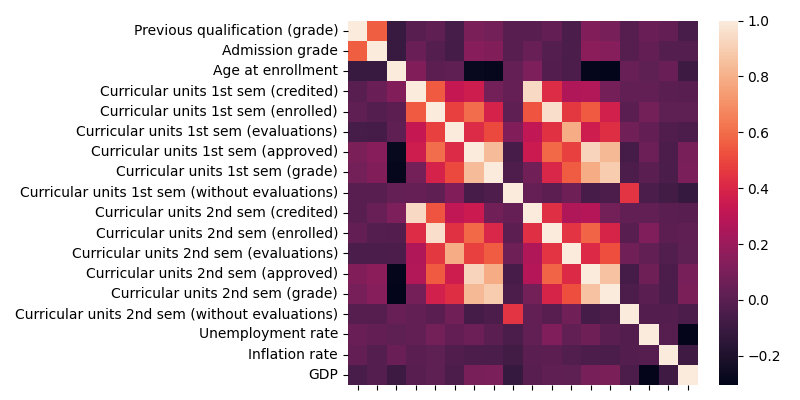

In [23]:
sc.cache_fig('corr_heatmap',
    lambda x:sns.heatmap(df_train[X_num].corr().rename(columns=lambda x: ''), ax=x), 
    figsize=(8, 4)
)

## Curricular 변수들

In [24]:
X_curr = [i for i in X_num if i.startswith('Curricular')]
X_curr

['Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)']

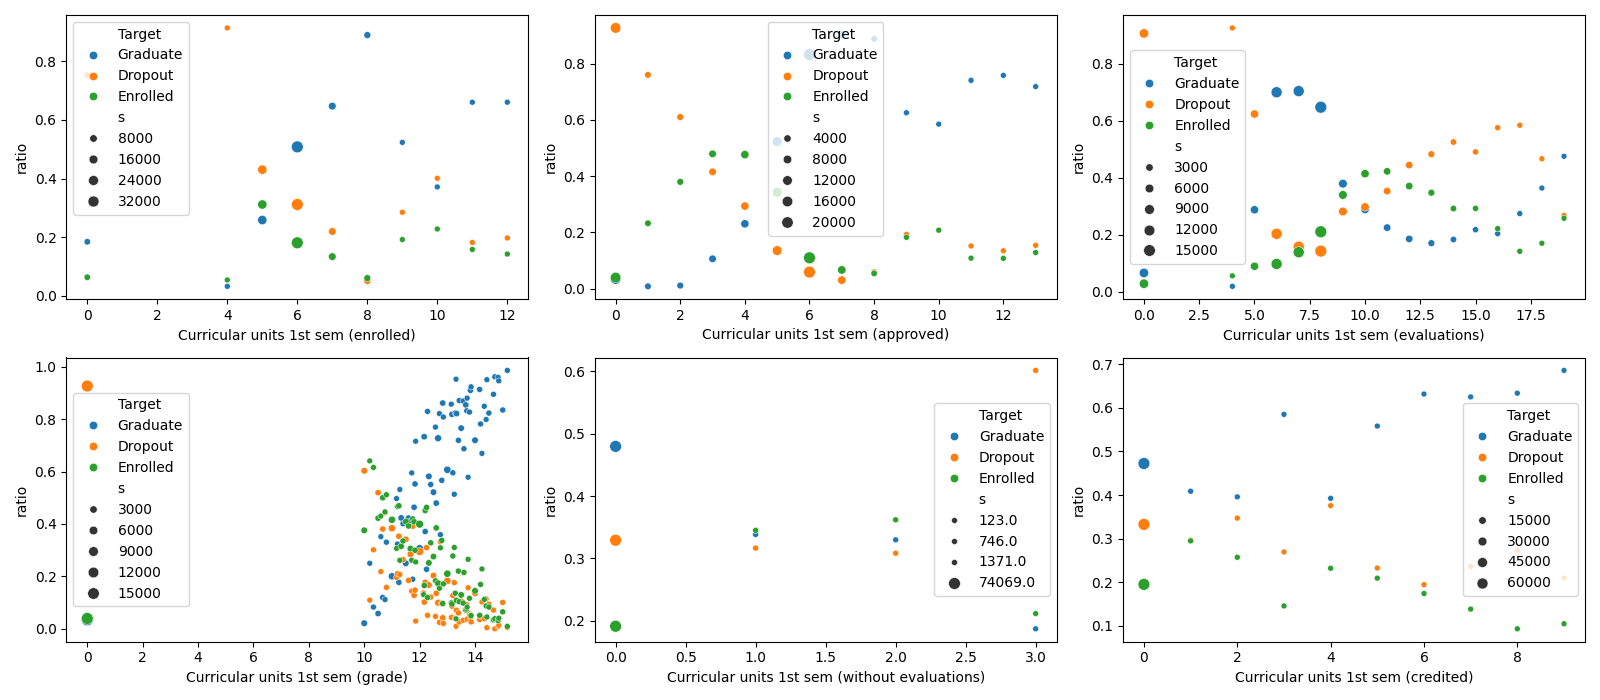

In [25]:
cur_1st = [
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 1st sem (credited)'
]

cur_2nd = [
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Curricular units 2nd sem (credited)'
]

def cur_ratio_plot(var, ax):
    df_train.pivot_table(
        index=var, columns=target, aggfunc='size', observed=True
    ).assign(
        s = lambda x: x.sum(axis=1)
    ).pipe(
        lambda x: x.loc[x['s'] >= 100]
    ).fillna(0).assign(
        Graduate = lambda x: x['Graduate'] / x['s'],
        Dropout = lambda x: x['Dropout'] / x['s'],
        Enrolled = lambda x: x['Enrolled'] / x['s'],
    ).reset_index().melt(id_vars=[var, 's']).rename(
        columns={'value': 'ratio'}
    ).pipe(
        lambda x: sns.scatterplot(x, x=var, y='ratio', hue=target, size='s', ax=ax)
    )
sc.cache_fig('cur_1st_target',
    lambda x: [cur_ratio_plot(i, ax) for i, ax in zip(cur_1st, x)],
    nrow=2, ncol=3, figsize=(16, 7)
)

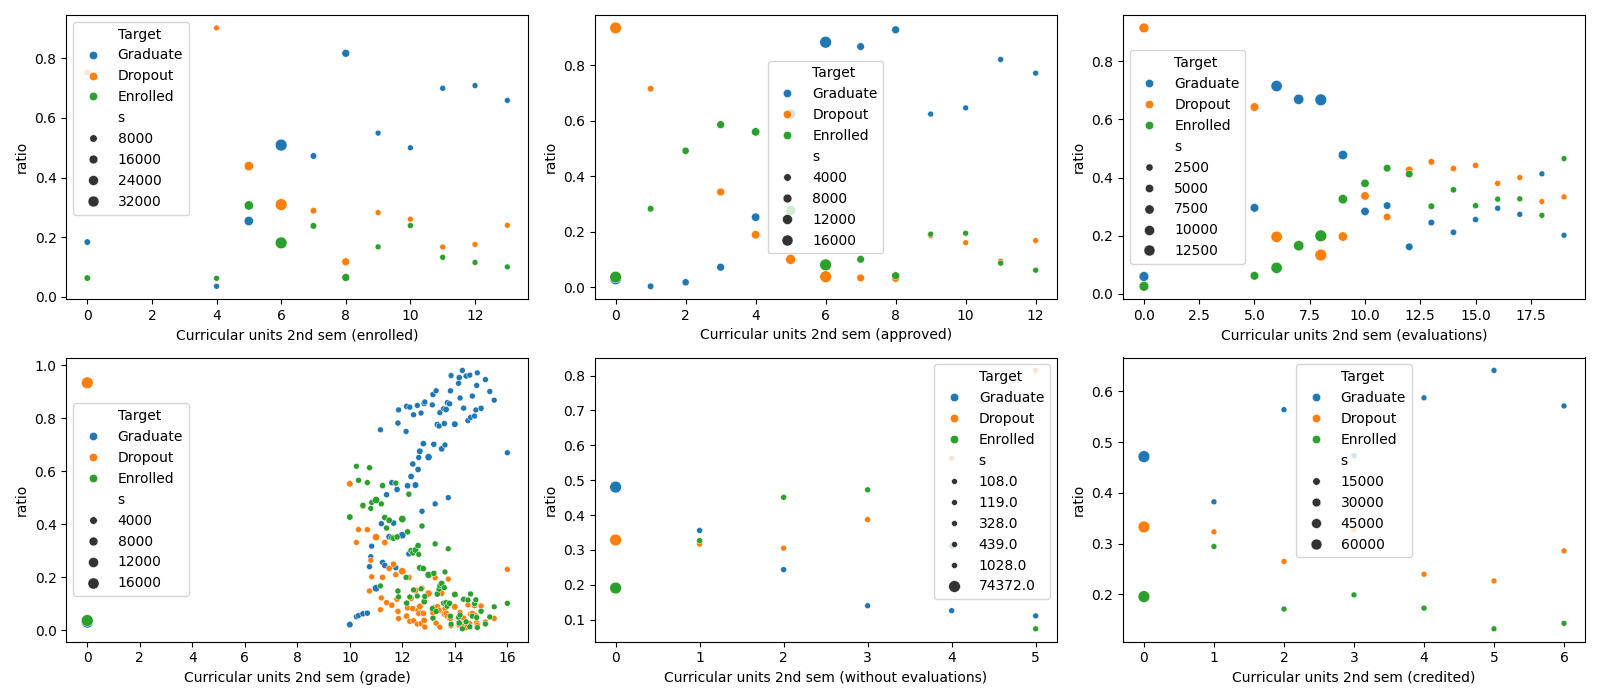

In [26]:
sc.cache_fig('cur_2st_target',
    lambda x: [cur_ratio_plot(i, ax) for i, ax in zip(cur_2nd, x)],
    nrow=2, ncol=3, figsize=(16, 7)
)

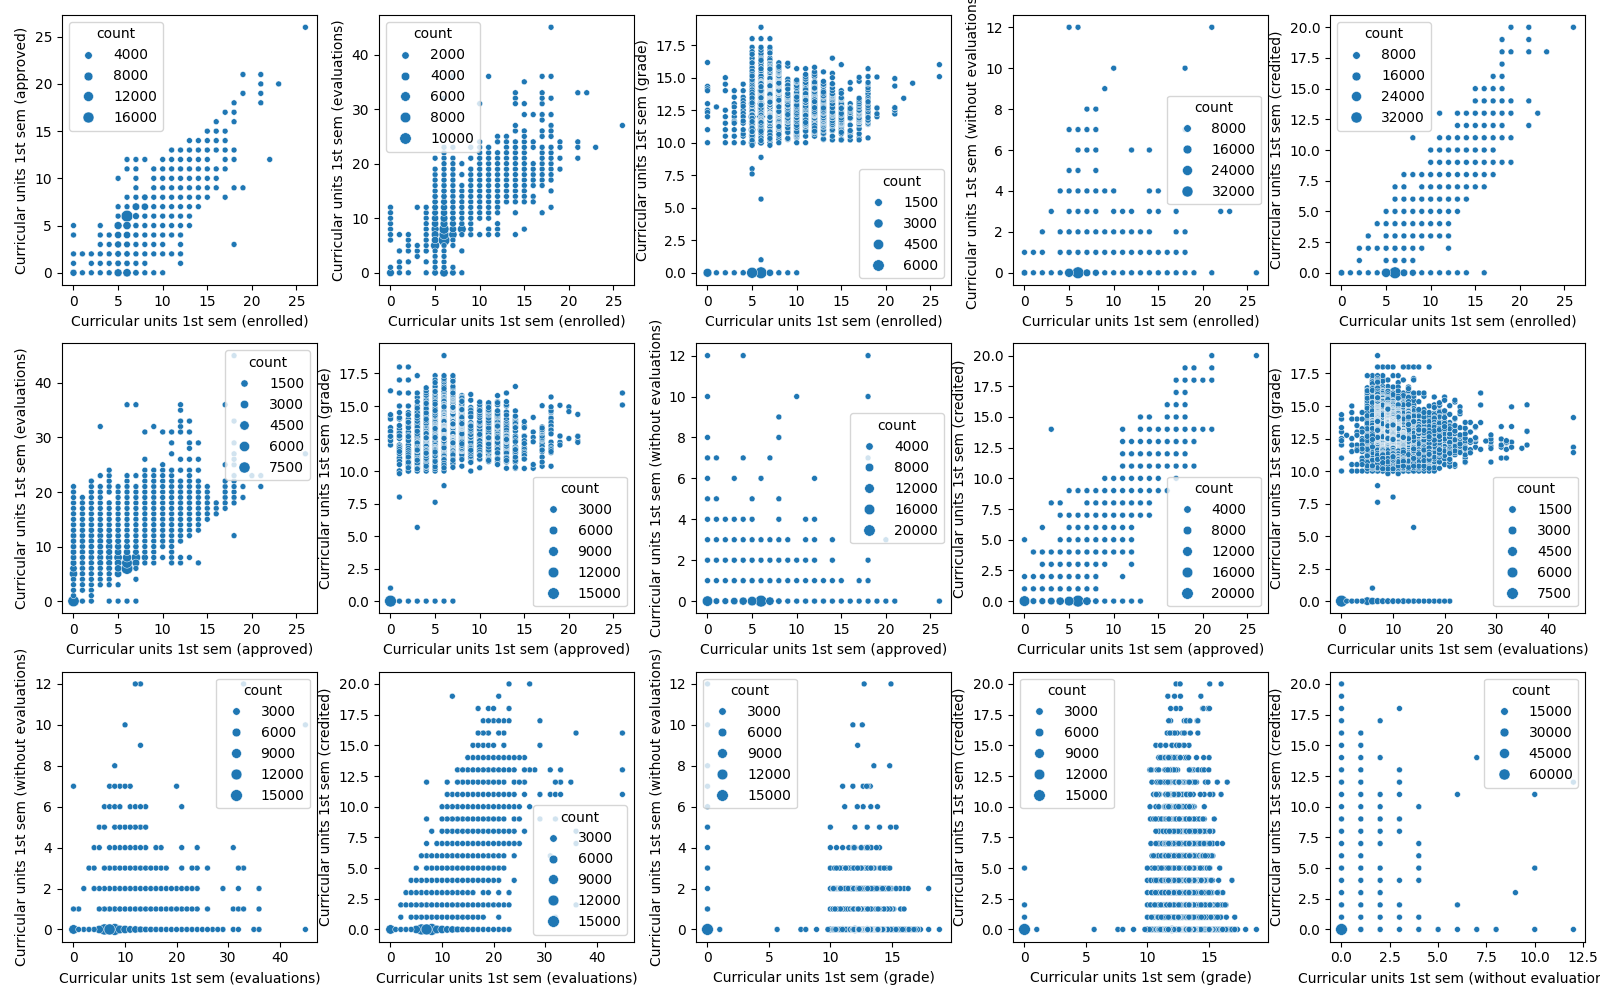

In [27]:
import itertools

def curr_2d_plot(a, b, ax):
    df_train[[a, b]].value_counts().reset_index().pipe(
        lambda x: sns.scatterplot(data=x, x = a, y = b, size = 'count', ax=ax)
    )

sc.cache_fig(
    'cur_2d_plots_1st', 
    lambda x: [
        curr_2d_plot(a, b, ax) for (a, b), ax in zip(itertools.combinations(cur_1st, 2), x)
    ], nrow=3, ncol=5, figsize=(16, 10)
)

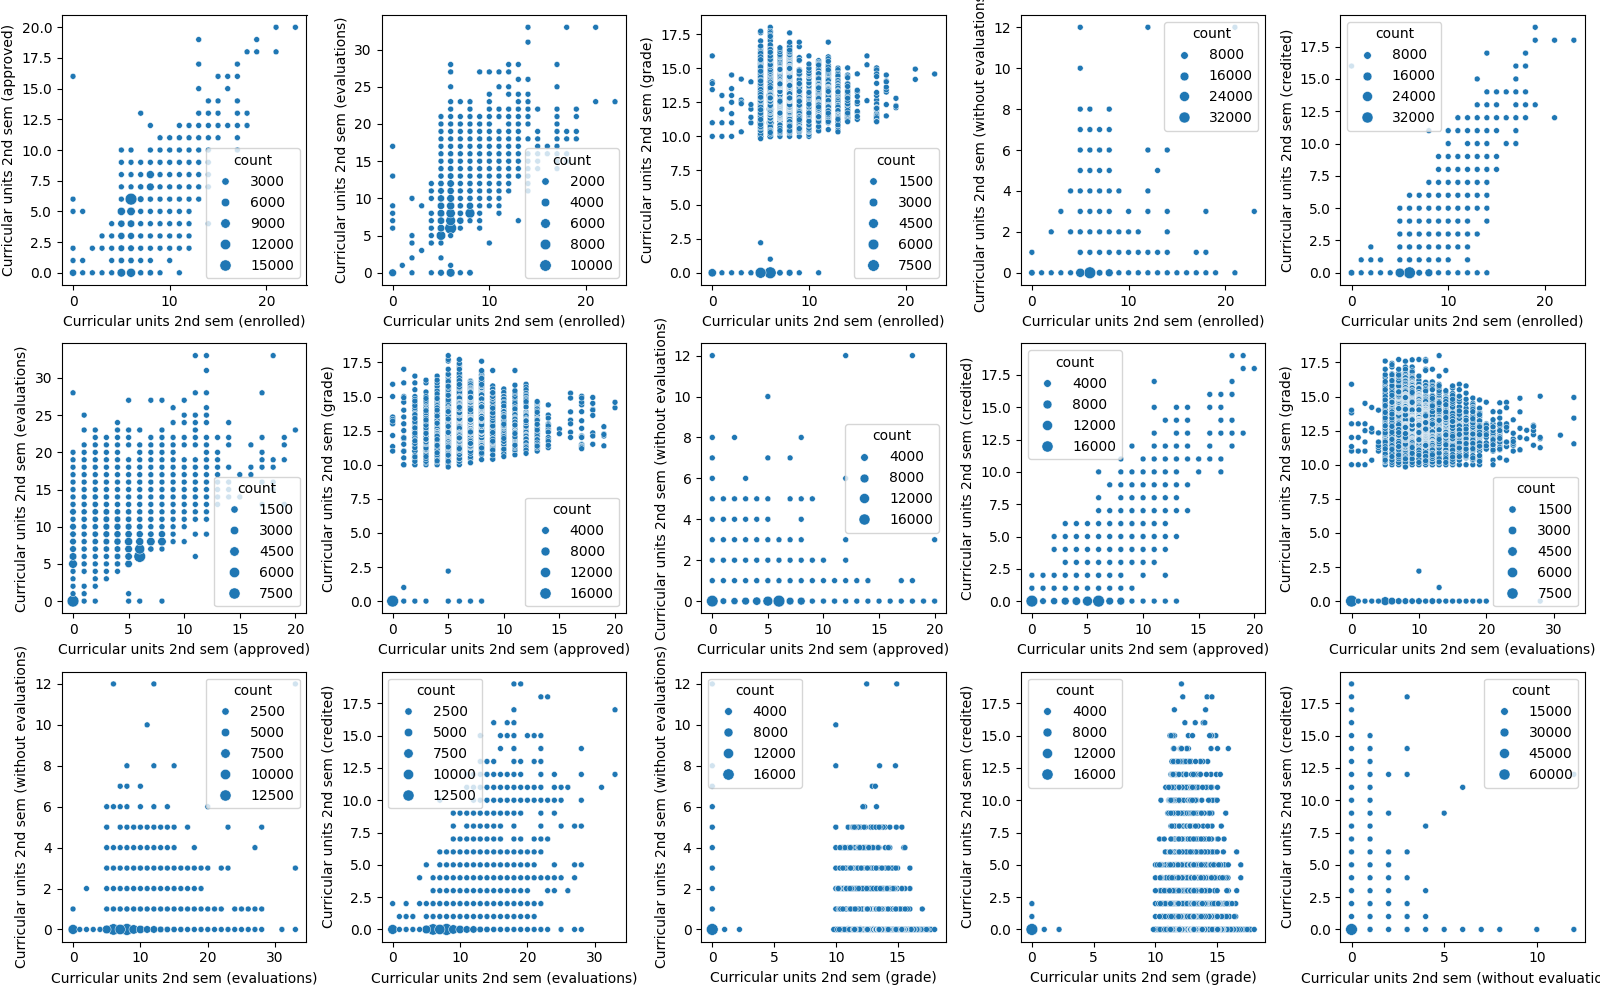

In [28]:
sc.cache_fig(
    'cur_2d_plots_2nd', 
    lambda x: [
        curr_2d_plot(a, b, ax) for (a, b), ax in zip(itertools.combinations(cur_2st, 2), x)
    ], nrow=3, ncol=5, figsize=(16, 10)
)

## Admission grade

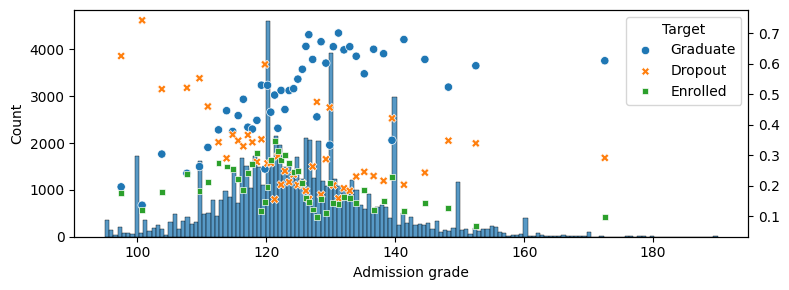

In [75]:
sc.cache_fig(
    'plot_admission_grade', lambda x: plot_hist_and_scatter_target(x, 'Admission grade')
)

## Previous qualification (grade)

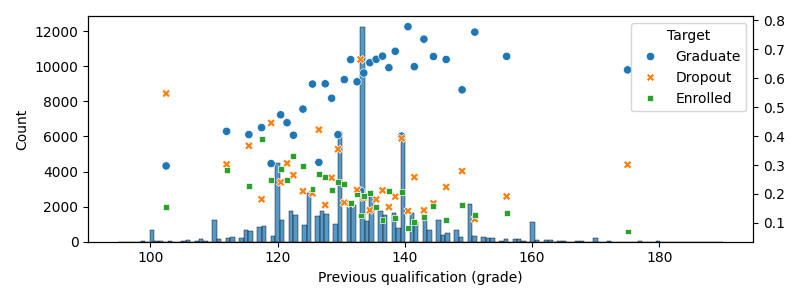

In [76]:
sc.cache_fig(
    'plot_prev_qual_grade', lambda x: plot_hist_and_scatter_target(x, 'Previous qualification (grade)')
)

## Age at enrollment

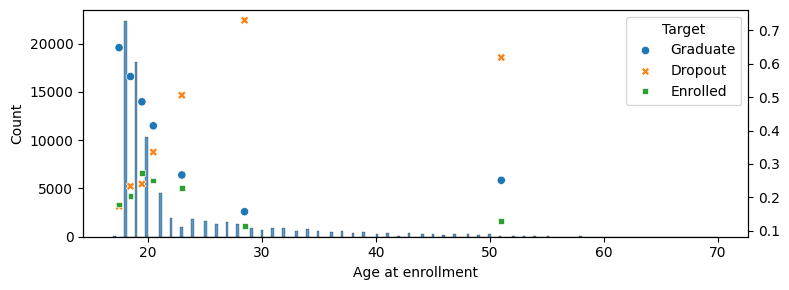

In [79]:
sc.cache_fig(
    'plot_age_enrollment', lambda x: plot_hist_and_scatter_target(x, 'Age at enrollment', 10)
)

In [78]:
df_var

,Role,Type,Demographic,Description,type,src,var_type
Marital status,Feature,Integer,Marital status,1 – single 2 – married 3 – widower 4 – divorce...,Categorical,org,Categorical
Application mode,Feature,Integer,NaN,1 - 1st phase - general contingent 2 - Ordinan...,Categorical,org,Categorical
Application order,Feature,Integer,NaN,Application order (between 0 - first choice; a...,Int8,org,Int8
Course,Feature,Integer,NaN,33 - Biofuel Production Technologies 171 - Ani...,Categorical,org,Categorical
Daytime/evening attendance,Feature,Integer,NaN,1 – daytime 0 - evening,Int8,org,Int8
Previous qualification,Feature,Integer,Education Level,1 - Secondary education 2 - Higher education -...,Int8,org,Int8
Previous qualification (grade),Feature,Continuous,NaN,Grade of previous qualification (between 0 and...,Float32,org,Float32
Nacionality,Feature,Integer,Nationality,1 - Portuguese; 2 - German; 6 - Spanish; 11 - ...,Categorical,org,Categorical
Mother's qualification,Feature,Integer,Education Level,1 - Secondary Education - 12th Year of Schooli...,Int8,org,Int8
Father's qualification,Feature,Integer,Education Level,1 - Secondary Education - 12th Year of Schooli...,Int8,org,Int8
